# CART - Mini-demo using reddit data
*Authors: Wesley Bosse (SEA) & Douglas Strodtman (SaMo) with minor edits by Adi Bronshtein (DC)*

## Overview:
- Create a validation set.
- Apply TFIDF.
- Gridsearch RandomForest.
- Predict subreddit.
- Interpret feature importances.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
reddit = pd.read_csv('data/reddit.csv')
reddit.head()

,Unnamed: 0,text,spiders
0,0,New job gave me the best badge ever,1
1,1,"After my golden orb weaver died, I comissioned...",1
2,2,Can we post memes on this sub?,1
3,3,This used a suspended pebble as an anchor po...,1
4,4,Is this a brown recluse? about 1 foot long,1


In [8]:
reddit.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
reddit.tail()

,text,spiders
1995,Isn't he so handsome,0
1996,Majestic shot!,0
1997,Awh❤️,0
1998,Any boops for a shy boy?,0
1999,Newest addition: Colt the Rough-scaled sand boa,0


In [10]:
reddit['spiders'].value_counts()

1    1000
0    1000
Name: spiders, dtype: int64

## Lets do something with that text.
If we want to have a true validation set, we will need to create a validation set before we apply TFIDF (or the IDF will be impacted by data from our test set).

Our target here will be the subreddit - `spiders` (or `snakes`).

In [17]:
# get rid of duplicates
reddit[reddit['text'].duplicated(keep=False) == True]

,text,spiders
12,Warning received.,1
30,Warning received.,1
290,"PSA: If you're cold, they're cold. Bring them ...",1
464,"PSA: If you're cold, they're cold. Bring them ...",1
1096,Blep,0
1189,.,0
1328,.,0
1796,Blep,0


In [18]:
reddit['text'].drop_duplicates(inplace=True)

In [21]:
# create X and y
X = reddit.drop('spiders', 1)
y = reddit['spiders']

In [22]:
X.head()

,text
0,New job gave me the best badge ever
1,"After my golden orb weaver died, I comissioned..."
2,Can we post memes on this sub?
3,This used a suspended pebble as an anchor po...
4,Is this a brown recluse? about 1 foot long


In [23]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: spiders, dtype: int64

In [24]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Remember that these will still be dataframes.

**Instantiate a TFIDF vectorizer**

In [25]:
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5)

**Create a corpus out of the list of titles. Fit and transform the vecotrizer on the corpus**

In [26]:
train_raw = tfidf.fit_transform(X_train['text'])

**Convert the vectorized data into a dataframe**

In [28]:
# use SparseDataFrame for space considerations
train_df = pd.SparseDataFrame(train_raw, columns=tfidf.get_feature_names())

train_df.head()

/Users/adibronshtein/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  
/Users/adibronshtein/anaconda3/lib/python3.7/site-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/Users/adibronshtein/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http

,10,100,absolutely,actually,addition,adorable,adult,ago,albino,amazing,...,wish,wolf,work,working,world,yard,year,years,yellow,yesterday
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's `fillna` with 0 (as all NaNs are just a result of the sparse representation).

In [29]:
train_df.fillna(0, inplace=True)

In [30]:
# check for missing values
train_df.isnull().sum()

/Users/adibronshtein/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return klass(values, index=self.index, name=items, fastpath=True)
/Users/adibronshtein/anaconda3/lib/python3.7/site-packages/pandas/core/sparse/series.py:585: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return self._constructor(arr, index=self.index).__finalize__(self)
/Users/adibronshtein/anaconda3/lib/python3.7/site-packages/pandas/core/sparse/frame.py:339: FutureWarning: SparseDataFrame is deprecated and will be rem

10            0
100           0
absolutely    0
actually      0
addition      0
             ..
yard          0
year          0
years         0
yellow        0
yesterday     0
Length: 313, dtype: int64

In [31]:
# check for missing values
train_df.isnull().sum().sum()

/Users/adibronshtein/anaconda3/lib/python3.7/site-packages/pandas/core/sparse/series.py:585: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return self._constructor(arr, index=self.index).__finalize__(self)
/Users/adibronshtein/anaconda3/lib/python3.7/site-packages/pandas/core/sparse/frame.py:339: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  default_fill_value=self.default_fill_value,


0

## Let's replicate this process for our X_test

In [33]:
test_raw = tfidf.transform(X_test['text'])

In [35]:
test_df = pd.SparseDataFrame(test_raw, columns=tfidf.get_feature_names())
test_df.fillna(0, inplace=True)

test_df.head()

/Users/adibronshtein/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  """Entry point for launching an IPython kernel.
/Users/adibronshtein/anaconda3/lib/python3.7/site-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/Users/adibronshtein/anaconda3/lib/python3.7/site-packages/pandas/core/sparse/frame.py:269: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    

,10,100,absolutely,actually,addition,adorable,adult,ago,albino,amazing,...,wish,wolf,work,working,world,yard,year,years,yellow,yesterday
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.713814,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fit a model using `spiders` as the target

**Instantiate the GridSearchCV for RandomForestClassifier, fit and score on the train data**

We'll start with 100 estimators and just search over `min_samples_split`.

In [36]:
params = {
    'min_samples_split': [10, 25, 50]
}

In [37]:
# define a RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)

In [39]:
# GridSearch
gs = GridSearchCV(rfc, param_grid=params, return_train_score=True, cv=5)
gs.fit(train_df, y_train)

/Users/adibronshtein/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3606: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  result = self._constructor(new_data).__finalize__(self)
/Users/adibronshtein/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3606: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  result = self._constructor(new_data).__finalize__(self)
/Users/adibronshtein/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3606: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are Sparse

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [40]:
gs.score(train_df, y_train)

0.8964285714285715

**Score on the test data**

In [41]:
gs.score(test_df, y_test)

0.7533333333333333

This looks pretty bad. Let's look at our hyperparameters.

In [42]:
gs.best_params_

{'min_samples_split': 10}

In [43]:
# Feature importance
gs.best_estimator_.feature_importances_

array([1.38242499e-03, 1.86957928e-03, 9.07313952e-04, 1.88791326e-03,
       7.08854288e-04, 1.96479633e-03, 8.57937186e-04, 1.08569671e-03,
       3.18162089e-03, 1.95309399e-03, 1.15163689e-03, 6.42993759e-04,
       3.71430642e-03, 4.94548501e-03, 7.62840731e-04, 7.40889173e-03,
       3.58729214e-03, 7.11684385e-04, 7.15507048e-03, 1.01727446e-02,
       1.54641200e-03, 3.84589712e-03, 1.15418910e-03, 7.57780629e-03,
       3.82297061e-03, 2.13632525e-03, 9.31156628e-04, 4.48563045e-03,
       1.48261627e-03, 2.42596308e-03, 4.12748879e-03, 1.59321134e-02,
       1.29545876e-03, 1.13671802e-03, 1.64988055e-02, 4.39800618e-03,
       2.48358984e-04, 1.88115260e-03, 1.20173958e-03, 7.55405227e-05,
       6.05493311e-04, 1.51215871e-03, 1.27279544e-03, 2.70662063e-03,
       5.32277168e-04, 4.17741656e-03, 1.64494062e-03, 2.74491816e-04,
       7.98836858e-04, 4.07851380e-03, 2.14155586e-04, 3.34024104e-03,
       1.41420663e-03, 1.20591039e-03, 3.06135054e-03, 2.55633101e-03,
      

In [44]:
# turn it into a data frame
features_df = pd.DataFrame(gs.best_estimator_.feature_importances_, train_df.columns, columns=['Importance'])
features_df

,Importance
10,0.001382
100,0.001870
absolutely,0.000907
actually,0.001888
addition,0.000709
...,...
yard,0.001439
year,0.003618
years,0.002365
yellow,0.001633


In [46]:
# most important features/words
features_df.sort_values(by='Importance', ascending=False).head(10)

,Importance
python,0.028508
jumping,0.027976
wolf,0.023563
shed,0.019569
tarantula,0.019082
noodle,0.018108
girl,0.017203
id,0.017177
boy,0.016499
boa,0.015932


In [47]:
# least important features/words
features_df.sort_values(by='Importance', ascending=True).head(10)

,Importance
great,0.000022
crazy,0.000045
burmese,0.000076
stunning,0.000086
curious,0.000096
western,0.000100
rainbow,0.000158
does,0.000166
makes,0.000201
check,0.000214


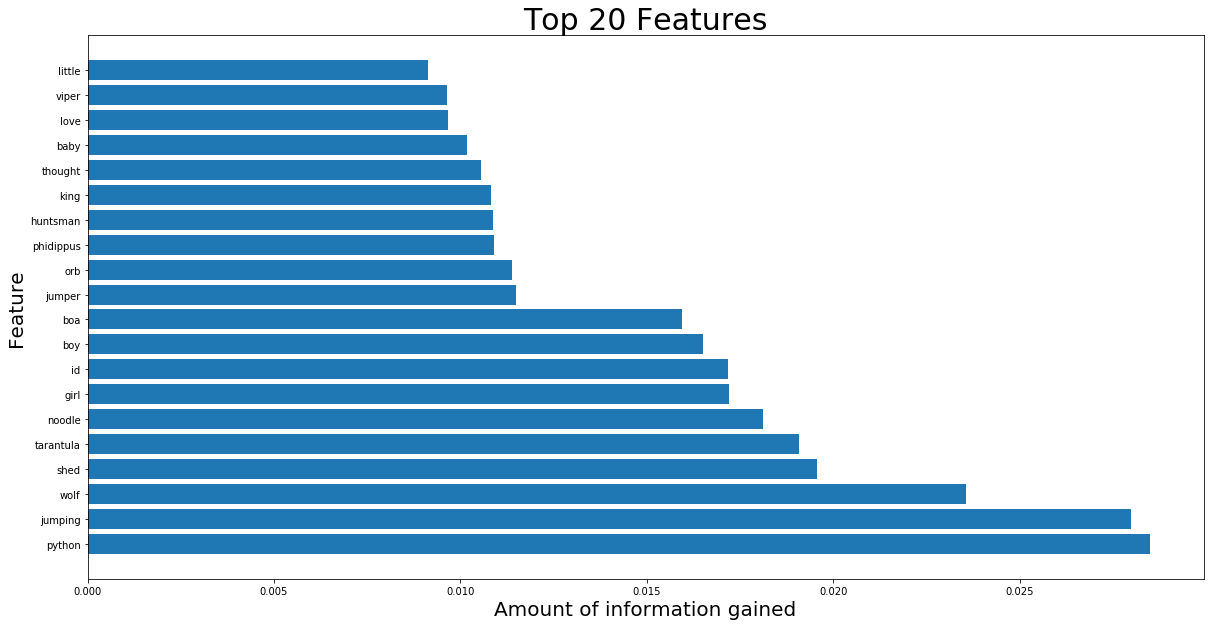

In [51]:
# plot the top features
plt.figure(figsize=(20,10))
temp = features_df.sort_values('Importance', ascending=False).head(20)
plt.barh(temp.index, temp['Importance'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of information gained', fontsize=20)
plt.ylabel('Feature', fontsize=20);

**We can also plot out our features to try to find the global optimum**

Text(0, 0.5, 'Mean Accuracy')

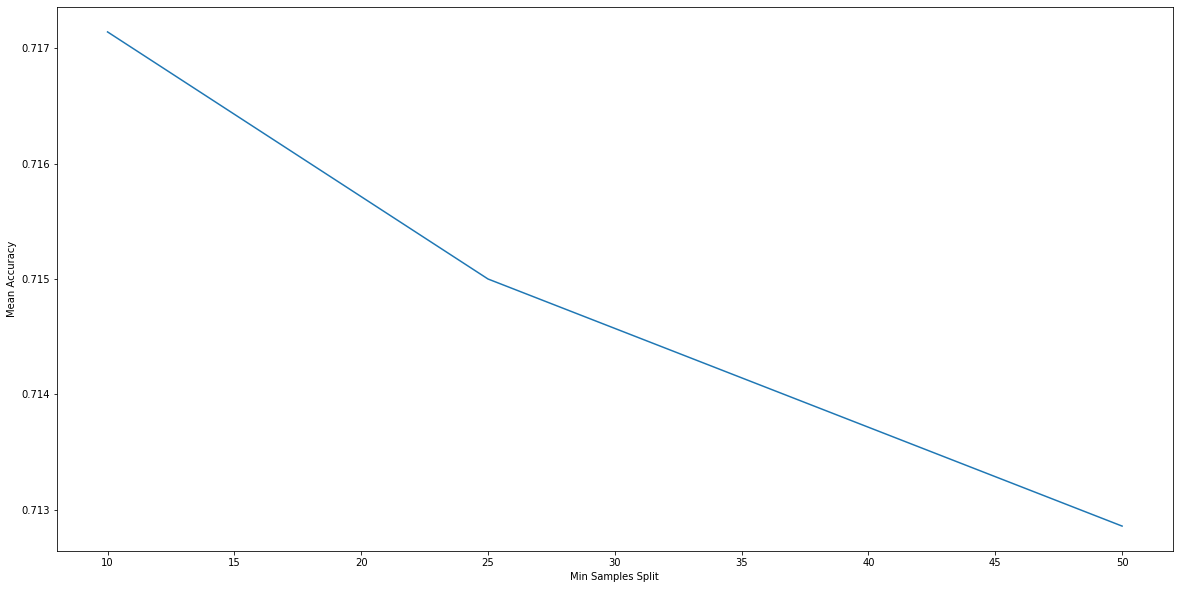

In [52]:
plt.figure(figsize=(20,10))
plt.plot([param['min_samples_split'] for param in gs.cv_results_['params']],
         gs.cv_results_['mean_test_score'])
plt.xlabel('Min Samples Split')
plt.ylabel('Mean Accuracy')